# Human brain DFPLC (Visium) - unsupervised clustering

In [ ]:
import spider
from spider import SPIDER

In [50]:
op=SPIDER()
import anndata
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [35]:
idata = anndata.read_h5ad('../example_data/human_brain_DLPFC/151510_idata.h5ad')
idata

AnnData object with n_obs × n_vars = 8988 × 1006
    obs: 'A', 'B', 'A_row', 'A_col', 'B_row', 'B_col', 'A_label', 'B_label', 'A_label_int', 'B_label_int', 'label_1', 'label_2', 'label_int', 'label', 'row', 'col', 'dist', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_count', 'som_node', 'A_label_layer_guess', 'B_label_layer_guess', 'A_label_int_layer_guess', 'B_label_int_layer_guess', 'label_layer_guess_int', 'label_layer_guess'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_meta', 'cell_pattern', 'lr_meta'
    obsm: 'pattern_score'

In [25]:
adata = anndata.read_h5ad('../example_data/human_brain_DLPFC/151510_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 4595 × 33538
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'Layer', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialD

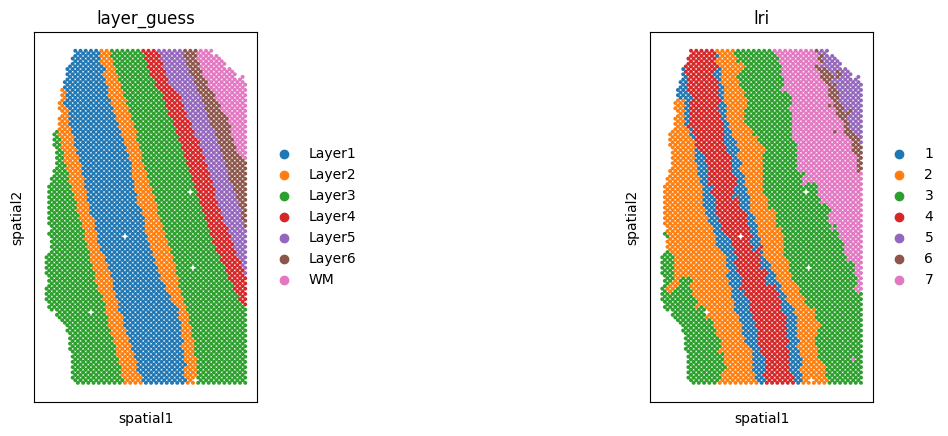

In [28]:
sc.pl.spatial(adata, color=['layer_guess', 'lri'], spot_size=1.5)

### Get marker LRIs

First, we transform LRIs to adata

In [41]:
op.util.interaction_spot_interface(idata)

Added key cell_score in idata.uns


In [42]:
lri_adata=anndata.AnnData(idata.uns['cell_score'])
lri_adata.obsm['spatial'] = adata.obsm['spatial']
lri_adata.obs = adata.obs

In [47]:
lri_adata.obs['lri_renamed'] = lri_adata.obs[['layer_guess', 'lri']].astype(str).agg('-'.join, axis=1).astype('category')
lri_adata.obs['lri_renamed'] = lri_adata.obs['lri_renamed'].astype('category').cat.rename_categories({
    'Layer1-1': 'White matter boundary',
    'Layer1-4': 'Layer 1',
    'WM-5': 'White matter',
    'WM-6': 'White matter boundary',
})

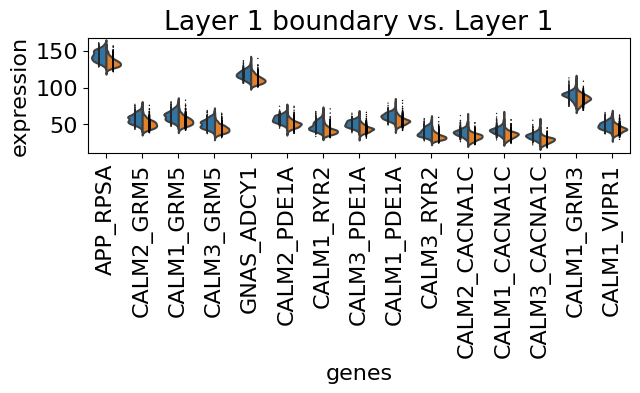

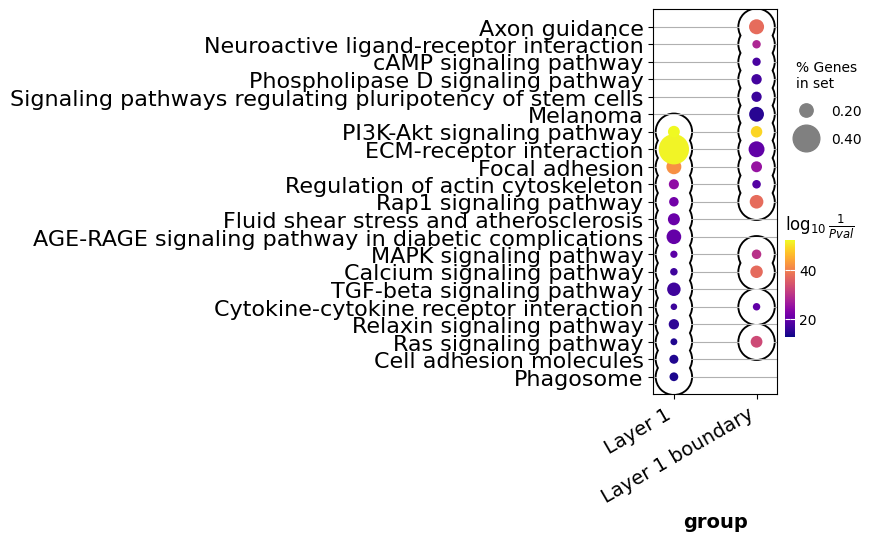

In [55]:
sc.tl.rank_genes_groups(lri_adata, 'lri_renamed', groups=['Layer 1 boundary'], reference='Layer 1', method='wilcoxon')
df = pd.concat([pd.DataFrame(lri_adata.uns['rank_genes_groups']['logfoldchanges']),
pd.DataFrame(lri_adata.uns['rank_genes_groups']['names'])
], axis=1)
df.columns = ['LFC', 'LRI']
df = df[np.abs(df['LFC'])>0.5]
df['group'] = 'Layer 1 boundary'
df.loc[df[df.LFC<0].index, 'group'] = 'Layer 1'
gene_names=df.loc[df.sort_values('LFC', ascending=False).index[:15], 'LRI']
with plt.rc_context({'figure.figsize': (7, 1.5), 'savefig.dpi': 300, "font.size" : 16} ):
    sc.pl.rank_genes_groups_violin(lri_adata, groups='Layer 1 boundary', 
    gene_names=gene_names.tolist(), jitter=0)

merged_df, arr = op.er.enrichment_interacrtion_gene_df(lri_adata, df.set_index('LRI'), groupby='group')
merged_df = merged_df[~merged_df.Term.str.contains('cancer|infection|Glioma|Toxoplasmosis|Shigellosis|Malaria|virus|Leish|Amoebiasis')]
op.vis.enrichment(merged_df, x_key='group', cutoff=0.01, top_term=15, size=8, figsize=(2, 5))

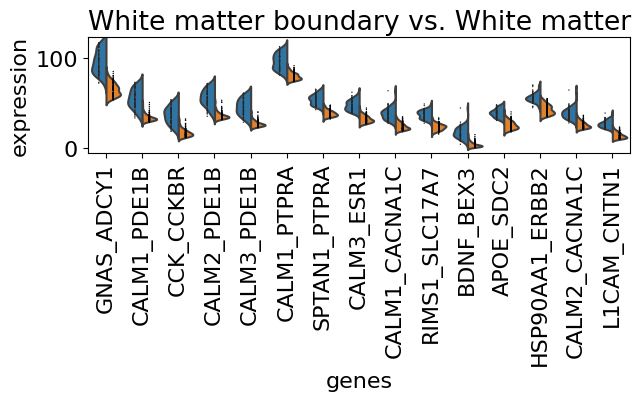

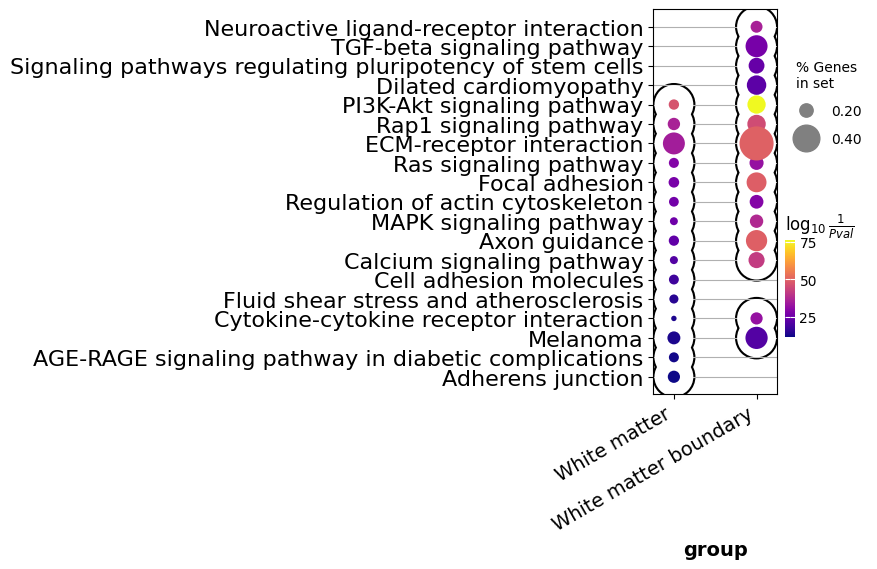

In [59]:
sc.tl.rank_genes_groups(lri_adata, 'lri_renamed', groups=['White matter boundary'], reference='White matter', method='wilcoxon')
df = pd.concat([pd.DataFrame(lri_adata.uns['rank_genes_groups']['logfoldchanges']),
pd.DataFrame(lri_adata.uns['rank_genes_groups']['names'])
], axis=1)
df.columns = ['LFC', 'LRI']
df = df[np.abs(df['LFC'])>0.5]
df['group'] = 'White matter boundary'
df.loc[df[df.LFC<0].index, 'group'] = 'White matter'
gene_names=df.loc[df.sort_values('LFC', ascending=False).index[:15], 'LRI']
with plt.rc_context({'figure.figsize': (7, 1.5), 'savefig.dpi': 300, "font.size" : 16} ):
    sc.pl.rank_genes_groups_violin(lri_adata, groups='White matter boundary', 
    gene_names=gene_names.tolist(), jitter=0)

merged_df, arr = op.er.enrichment_interacrtion_gene_df(lri_adata, df.set_index('LRI'), groupby='group')
merged_df = merged_df[~merged_df.Term.str.contains('cancer|infection|Glioma|Toxoplasmosis|Shigellosis|Malaria|virus|Leish|Amoebiasis')]
op.vis.enrichment(merged_df, x_key='group', cutoff=0.01, top_term=15, size=8, figsize=(2, 5))